In [1]:
# Import the required libraries

import warnings  # To avoid warnings
import pandas as pd
import numpy as np  # For mathematical operations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime  # To access datetime
from pandas import Series  # To work on series
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Load train and test data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Make of copy so even if we do changes we do not lose the original
train_original = train.copy()
test_original = test.copy()

In [3]:
# Inspect the datasets

train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

We have ID, Datetime and Count in the train dataset, and ID and Datetime in the test. We want to predict the Count for the latter.

Let's understand each column first: <br>
    * ID is the unique number given to each observation point 
    * Datetime is the time of each observation 
    * Count is the passenger count corresponding to each Datetime

In [4]:
# Check datatype of each feature

train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

ID and Count are in integer format while Datetime is an object in both datasets.

In [5]:
# Shape of the datasets

train.shape, test.shape

((18288, 3), (5112, 2))

We have 18288 different records for the Count of passenger in the train set and 5112 in the test set.

In [9]:
# As Datetime feature is an object we have to convert it to Datetime format in every dataset.

train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(
    train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(
    test_original.Datetime, format='%d-%m-%Y %H:%M')

In [10]:
# Extract the year, month, day and hour from Datetime.

for i in (train, test, train_original, test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

There are different traffic patterns depending on whether it is weekday or weekend. Let's make a weekend variable to check this.
    * First we will extract the day of the week from Datetime and based on the values assing if it is weekday or weekend.
    * values of 5 and 6 represents that days are weekend.

In [11]:
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

Let's assing 1 if the day is weekend and 0 if it's not

In [12]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0


temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2

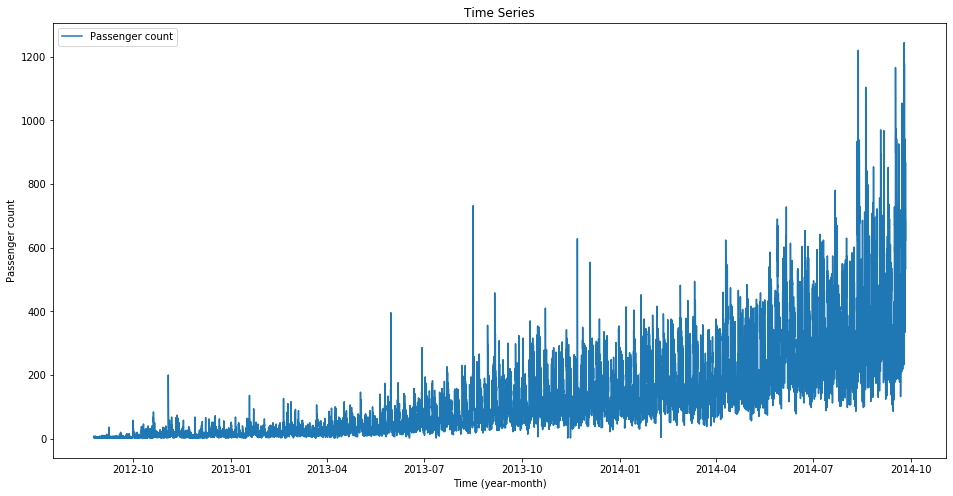

In [14]:
# Let's look at the time series

# Indexing the Datetime to get the time period on the x-axis
train.index = train['Datetime']
df = train.drop('ID', 1)  # Dropping ID variable to get only time in the x-axis
ts = df['Count']
plt.figure(figsize=(16, 8))
plt.plot(ts, label='Passenger count')
plt.title('Time Series')
plt.xlabel('Time (year-month)')
plt.ylabel('Passenger count')
plt.legend(loc='best')

We can infer that there is an increasing trend in the series; the number of passengers is increasing over time. Also we can see that are sudden peaks in the graph. This could be on certain days of the years that the traffic was higher.

We will work on the train set for the analysis and forecast using the test set.

Let's recall the hypothesis that we made earlier:
    * Traffic will increase as the years pass by  
    * Traffic will be higher from May to October
    * Traffic on weekdays will be higher
    * Traffic during the peak hours will be higher
After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset

Our first hypothesis as traffic will increase as the years pass by. Let's check at yearly passenger count.

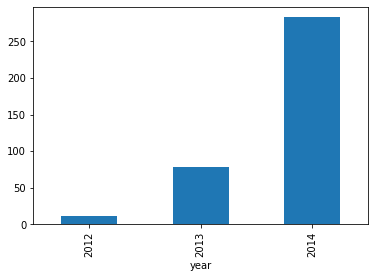

In [15]:
train.groupby('year')['Count'].mean().plot.bar()

We see an exponential growth so our hypothesis is validated

Traffic will increase from May to October. We check the means of every month

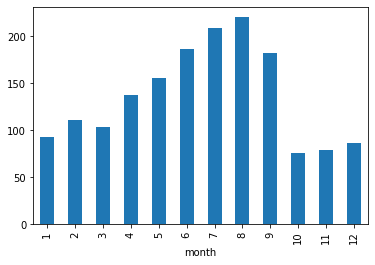

In [16]:
train.groupby('month')['Count'].mean().plot.bar()

There's a big decrease in the last three months, this looks odd. Let's look the monthly mean at each year.

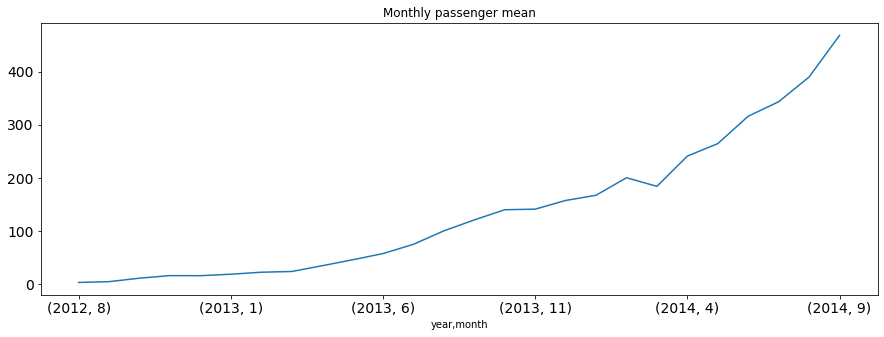

In [17]:
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15, 5), title='Monthly passenger mean', fontsize=14)

We see that 2014 does not have the last 3 months, and the mean value of the months in 2012 is really less. We can also see an increasing trend over time that growths almost exponentially.

Let's look at the daily mean of the number of passengers

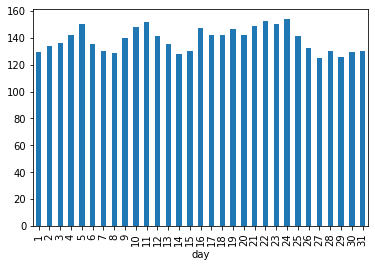

In [18]:
train.groupby(['day'])['Count'].mean().plot.bar()

Not getting much information from the daily counts.

We also infer that the traffic will be higher during peak hours. Let's check the hourly means.

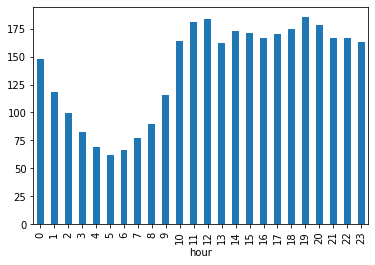

In [19]:
train.groupby(['hour'])['Count'].mean().plot.bar()

It can be infer that peak traffic is at 7 pm and then starts decreasing until 5 am when it rises again to 11-12 noon.

Let's check if traffic is higher during weekdays

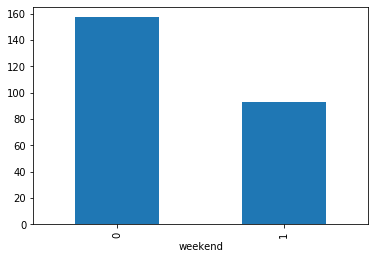

In [20]:
train.groupby(['weekend'])['Count'].mean().plot.bar()

The mean count over weekdays is almost the double of the one during weekends. This validate the hypothesis.

Now we will take a look at the number of passenger that travel each day of the week.

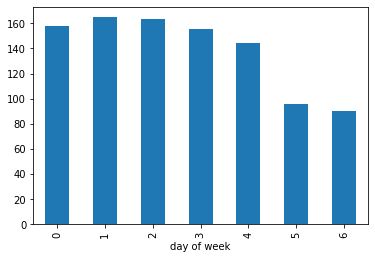

In [21]:
train.groupby('day of week')['Count'].mean().plot.bar()

From the above plot we can infer that number of passenger during the weekend is less than during weekdays. Now we will look at basic modeling techniques, but before that we are going to drop the ID feature.

In [22]:
train = train.drop('ID', 1)

As there is a lot of noise in our time series, we will aggregate the hourly time series to daily, weekly and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y%H:%M')
train.index = train.Timestamp
# Hourly time series
hourly = train.resample('H').mean()
# Converting to daily mean
daily = train.resample('D').mean()
# Converting to daily weekly
weekly = train.resample('W').mean()
# Converting to monthly mean
monthly = train.resample('M').mean()

Let's take a look at the graphs.

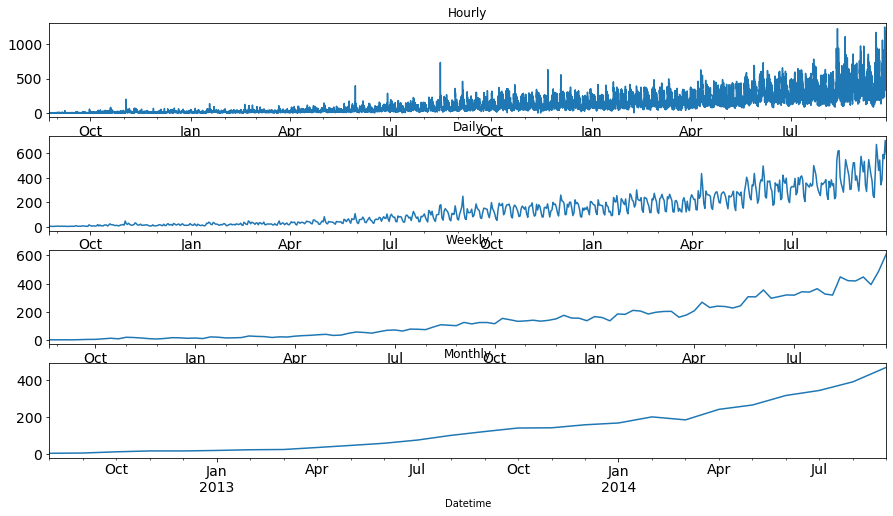

In [24]:
fig, axs = plt.subplots(4, 1)
hourly.Count.plot(figsize=(15, 8), title='Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15, 8), title='Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15, 8), title='Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15, 8), title='Monthly', fontsize=14, ax=axs[3])
plt.show()

We can see that the time series is becoming more stable as we aggregate it during larger periods of time. We will work on the daily time series, as converting from monthly to weekly and then daily requires too many steps.

In [25]:
# Converting to daily mean both train and test datasets

test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y%H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y%H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()

As we validated our hypothesis let's build some forecasting models. For this we will need a validation dataset to check the performance and generalization ability of our model. Some of the properties of this dataset are:
    * The dataset should have the true values of the dependent variable against which the predictions can be checked.Therefore, the test set can't be used.
    * The model should not be trained on the validation dataset.

So for the above reasons we generally divide the train set in two: train and validation.



We will make our model on the train set and predict with the validation set to check the accuracy of our model.

For the validation set we will take the last 3 months and the remaining ones are used for training. Taking more months for validation will result in a smaller amount of data to train, as we have only have 25 months and thus a worse model.

In [26]:
# As we have seen in the exploration part, the starting date is 25-08-2012 and the end date is 25-09-2014.

Train = train.loc['2012-08-25':'2014-06-24']
valid = train.loc['2014-06-25':'2014-09-25']

Let's take a look at how the original train dataset was divided in Train and valid

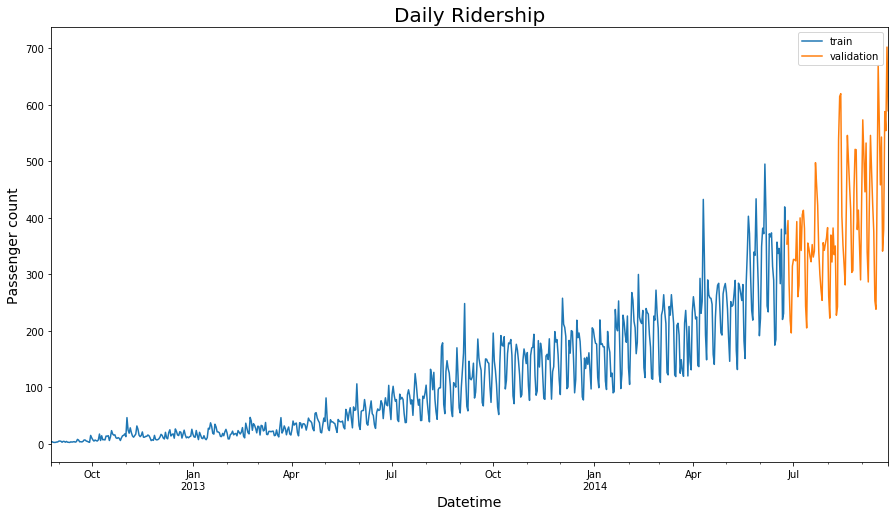

In [27]:
Train.Count.plot(figsize=(15, 8), label='train')
valid.Count.plot(figsize=(15, 8), label='validation')
plt.title('Daily Ridership', fontsize=20)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Passenger count', fontsize=14)
plt.legend(loc='best')
plt.show()

We will predict the traffic for the validation set and check how goo our prediction is. Finally we will make predictions on the test set using the ARIMA model.

ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).
    * p is the order of the autoregressive model (number of time lags)
    * d is the degree of differencing (number of times the data have had past values subtracted)
    * q is the order of moving average model.

The ARIMA forecasting for a stationary time series is nothing but a linear equation. There are three criterion for a series to be classified as stationary:
    * The mean should be constant
    * The variance of the time series should not be a function of time
    * The covariance of the ith term and the (i+m)th term should not be a function of time
    
We make the time series stationary to make the variables independent. Variables can be dependent in many ways but independent in only one, thus we get more information when they are independent.

If time series is not stationary firstly we have to make it stationary. For doing so, we need to remove the trend an seasonality.

#### Stationary Check ####

    * We use the Dick Fuller test to check the stationarity of the time series
    * The intuition behind this test is that determines how strongly a time series is defined by a trend.
    * The null hypothesis is that the time series is not stationary (has some time-dependent structure).
    * The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test result comprise of a Test Statistic and some Critical Value for difference confidence level. If the 'Test Statistic' is less than the Critical Value we can reject the null hypothesis and say that the time series is stationary.


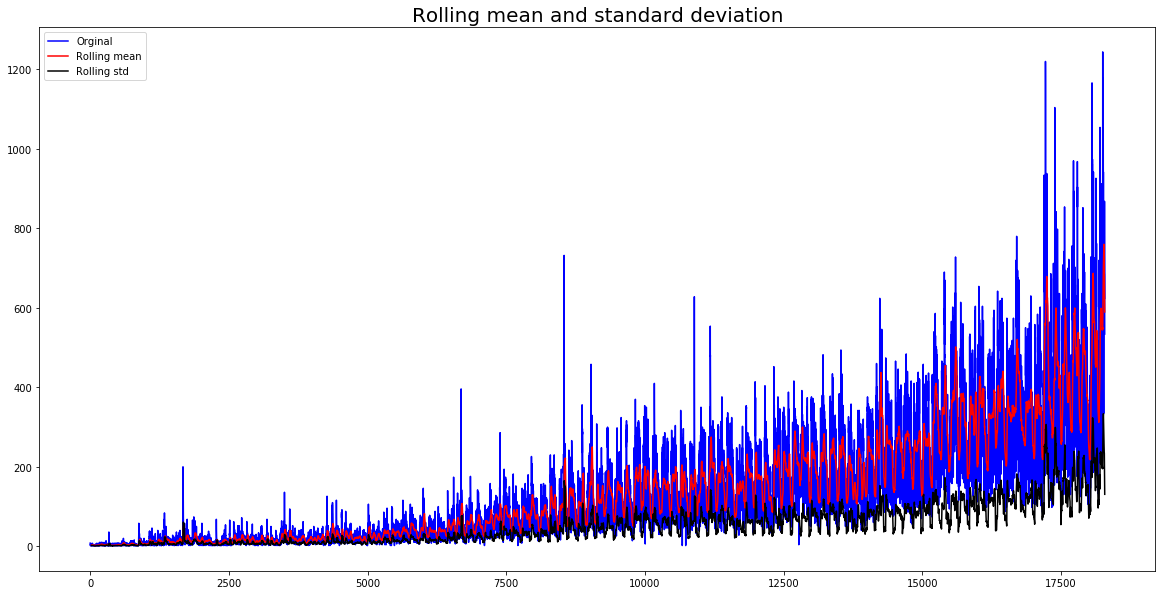

Results of Dick-Fuller test
Test Statistic                    -4.456561
p-value                            0.000235
# Lags used                       45.000000
Number of observations used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [28]:
# Let's make a function to calculate the Dick Fuller test
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller


def test_stationarity(train_original):
    # Determining rolling statistics
    rolmean = train_original.rolling(24).mean()  # 24hs on each day
    rolstd = train_original.rolling(24).std()
    # Plot rolling statistics
    orig = plt.plot(train_original, color='blue', label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and standard deviation', fontsize=20)
    plt.show(block=False)

    # Perform Dick-Fuller test
    print('Results of Dick-Fuller test')
    dftest = adfuller(train_original, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '# Lags used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


rcParams['figure.figsize'] = 20, 10

test_stationarity(train_original['Count'])

The statistics shows that this is a stationary time series as Test Statistic < Critical Value, but it can be seen an increasing trend in the plot. So firstly, we will make the time series more stationary by removing its trend.

#### Removing trend ####
    * A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.
    * We see an increasing trend in the data so we can implement a transformation that penalizes higher values more than smaller, such as log transformation.
    * We will take rolling average to remove the trend. We will take a window size of 24 hours based on the fact that each day has 24 hours.

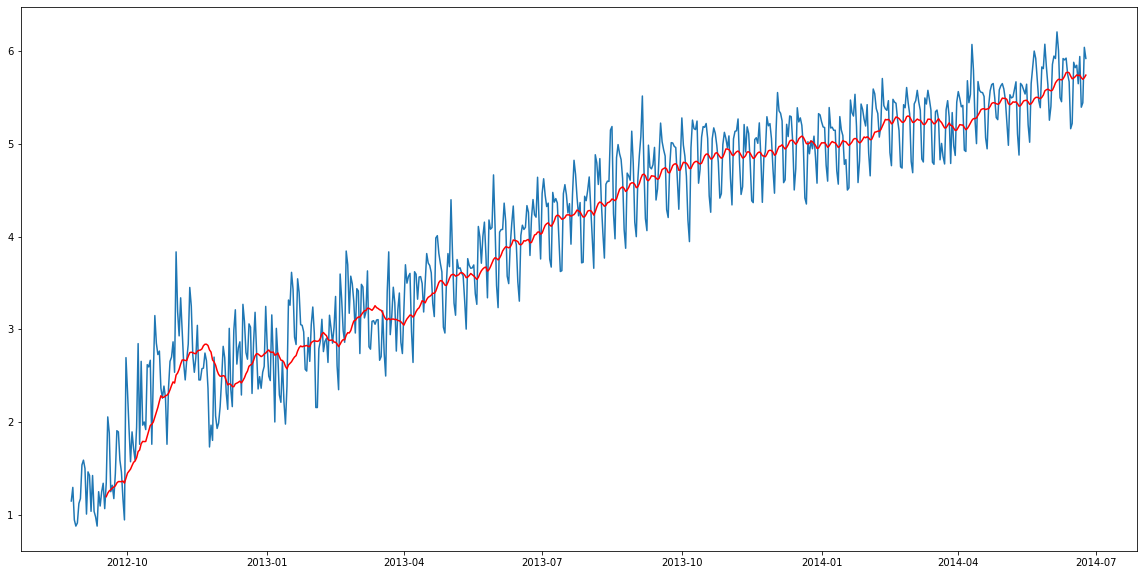

In [29]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color='red')
plt.show()

We can observe and increase trend, so we will remove it to make out time series stationary

In [30]:
train_log_moving_avg_diff = Train_log-moving_avg

Since we took the average of 24 values, the first 23 values are null so we drop this ones.

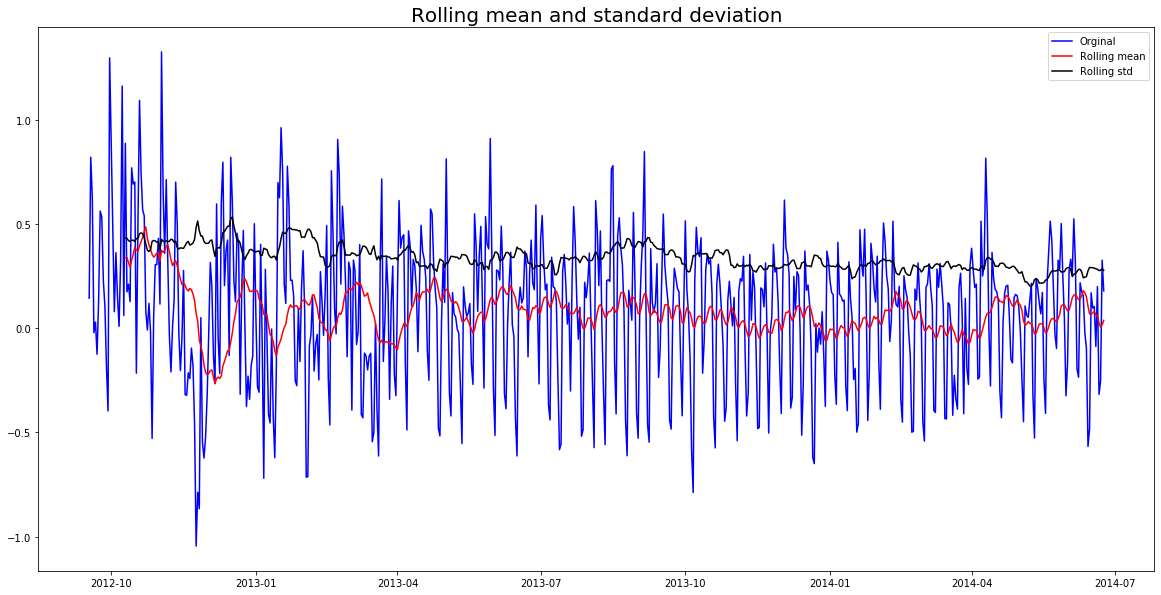

Results of Dick-Fuller test
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
# Lags used                    2.000000e+01
Number of observations used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [31]:
train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is even smaller in this case than the Critical Value, so we can be confident that the trend has been removed.

Let's now stabilize the mean of the time series which is also a requirement for a stationary time series.
    * Differencing can help to make the series stable and eliminate the trend
    

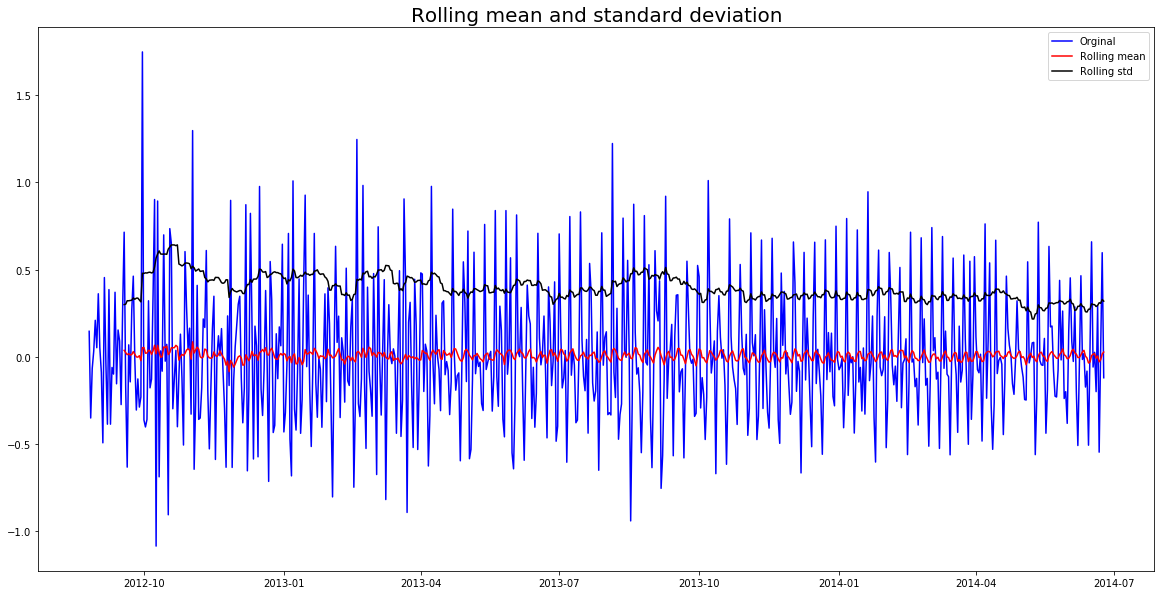

Results of Dick-Fuller test
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
# Lags used                    1.900000e+01
Number of observations used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [32]:
train_log_diff = Train_log-Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation of the series.

#### Removing seasonality ####
    * By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors(e.g. the month, day of the week, etc)
    * Seasonality is always of a fixed and known period.
    * We will use seasonal decompose to the decompose the time series into trend, seasonality and residuals.

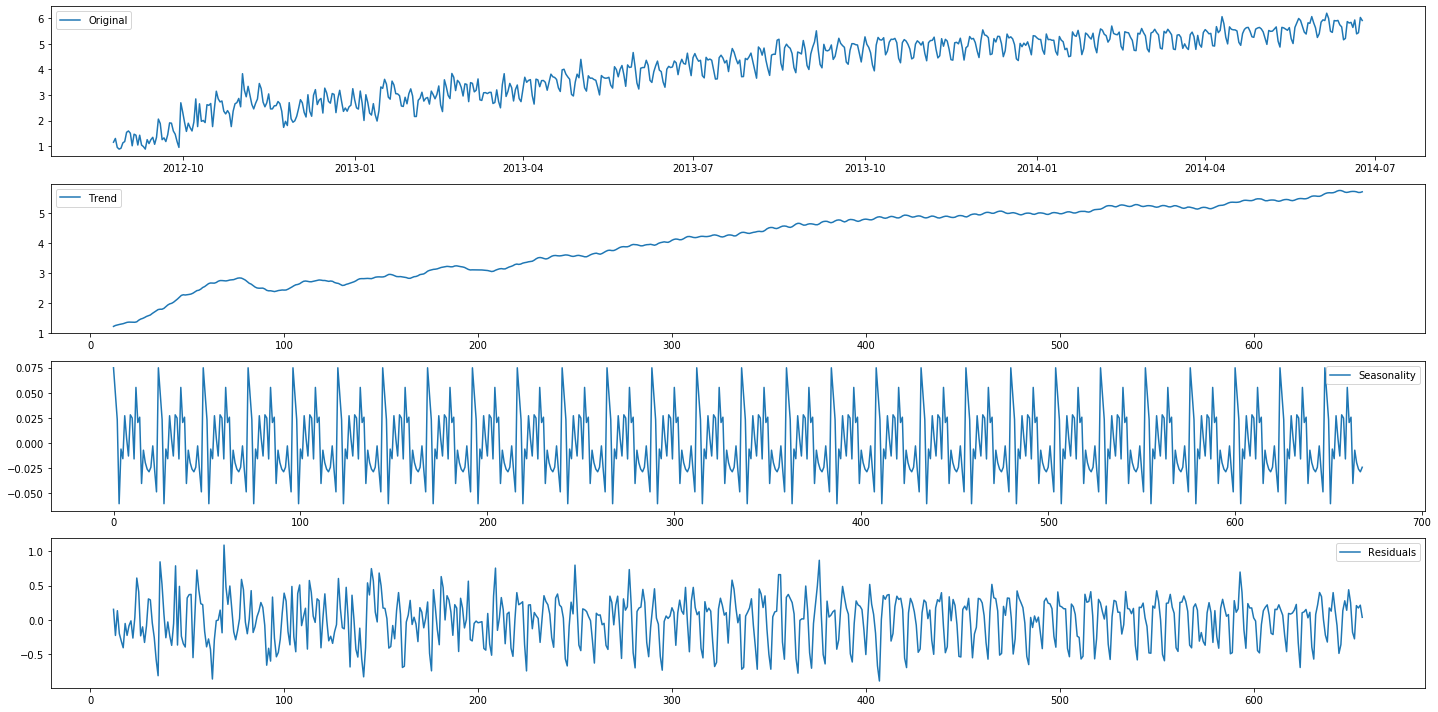

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    pd.DataFrame(Train_log).Count.values, freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see trend, seasonality and residuals clearly in the above graph. Seasonality shows a constant trend in the counter.

Let's check stationarity of residuals.

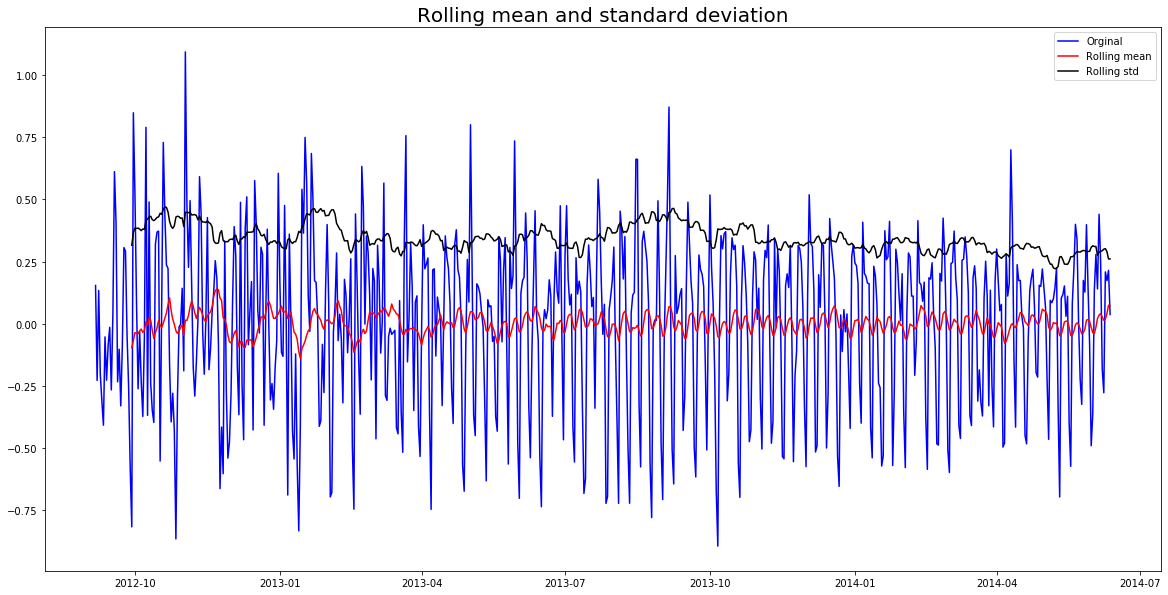

Results of Dick-Fuller test
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
# Lags used                    2.000000e+01
Number of observations used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [34]:
train_log_decompose=pd.DataFrame(residual)
train_log_decompose['date']=Train_log.index
train_log_decompose.set_index('date',inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

From the results it can be interpreted that the residuals are also stationary

#### Forecasting using ARIMA ####

    * First of all we will fit the ARIMA model on our time series. For that we hace to find the p, d, and q parameters.
    * To find the optimized values of these parameters we will use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) graph.
    * ACF is a measure of the correlation of the time series and a lagged version of itself.
    * PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained  by the intervening comparisons.

In [35]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

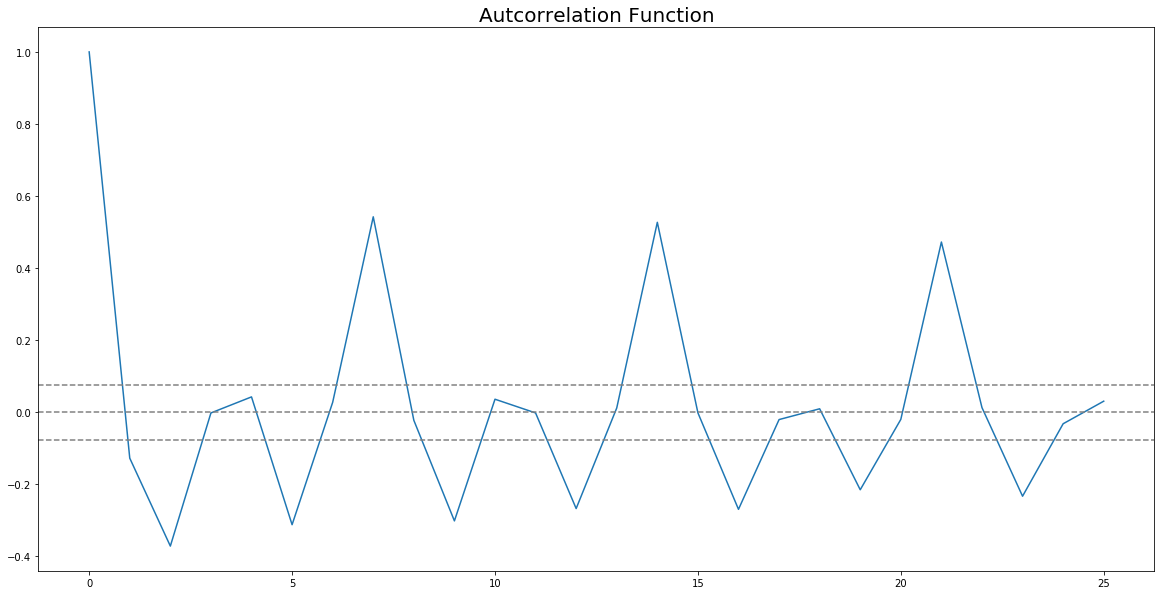

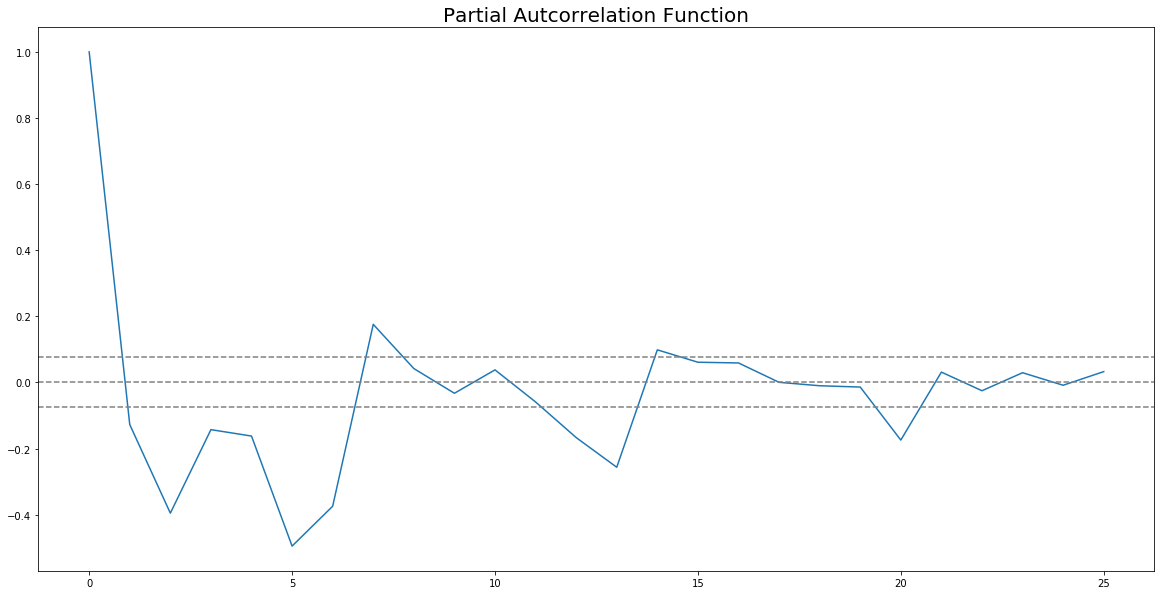

In [36]:
#ACF and PACF plot

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') #1.96 is the 95% prediction interval
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autcorrelation Function',fontsize=20)
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') #1.96 is the 95% prediction interval
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autcorrelation Function',fontsize=20)
plt.show()

    * p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. In this case p = 2.
    * q value is the lag values where the ACF chart crosses the upper confidence interval for the first time. In this case q = 2.
    
Now we will make the ARIMA model as we have the p and q values. We will make the AR and MA model separately and then combine them together.

#### AR model ####

The autoregressive model specifies that the output variable depends linearly on its own previous values.

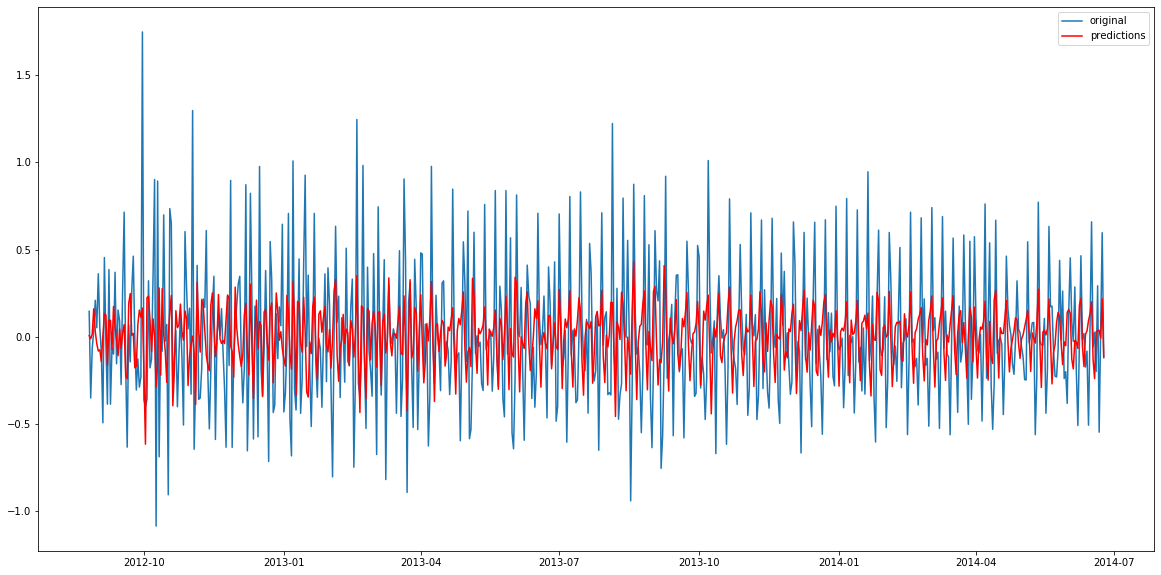

In [37]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(Train_log,order=(2,1,0)) #here the q value is 0 as it is just the AR model
results_AR=model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red',label='predictions')
plt.legend(loc='best')
plt.show()

Let's plot the validation for AR model.

We have to change the scale of the model to the original scale. So we need to compensate the differencing and the log transformation.

First step would be to store the predicted results as a separate series and observe it.

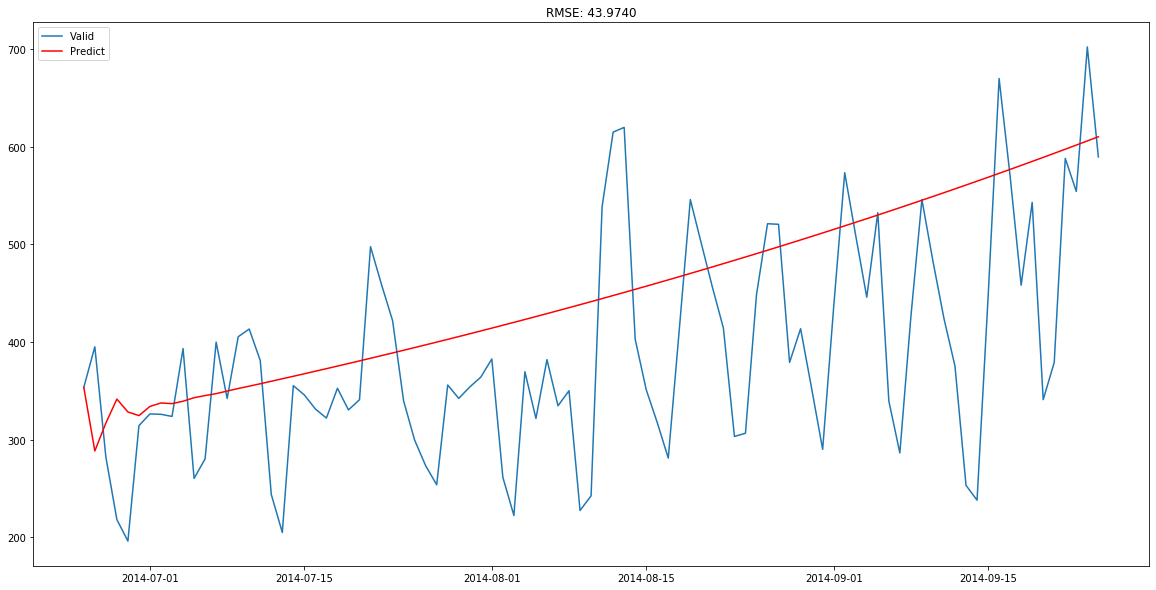

In [38]:
AR_predict = results_AR.predict(start='2014-06-25', end='2014-09-25')
AR_predict = AR_predict.cumsum().shift().fillna(0) #cumsum is applied to compensate the differencing performed
AR_predict1 = pd.Series(
    np.ones(valid.shape[0])*np.log(valid['Count'])[0], index=valid.index)
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
AR_predict = np.exp(AR_predict1)

plt.plot(valid['Count'], label='Valid')
plt.plot(AR_predict, color='red', label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f' %
          (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

Here the red line represents the prediction for the validation test. Now let's build the MA model.

#### MA model ####

The moving average model specifies that output variables depends linearly on the current and various past values of stochastic term.

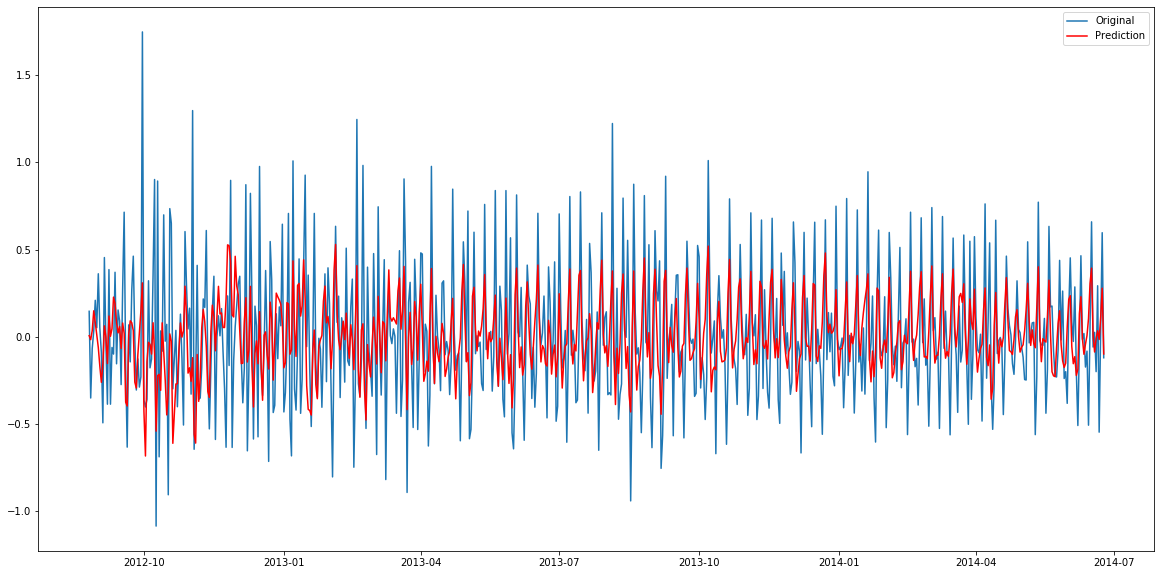

In [39]:
model=ARIMA(Train_log,order=(0,1,2)) #here the p value is 0 as it is just a MA model
results_MA=model.fit(disp=-1)
plt.plot(train_log_diff.dropna(),label='Original')
plt.plot(results_MA.fittedvalues,color='red',label='Prediction')
plt.legend(loc='best')
plt.show()

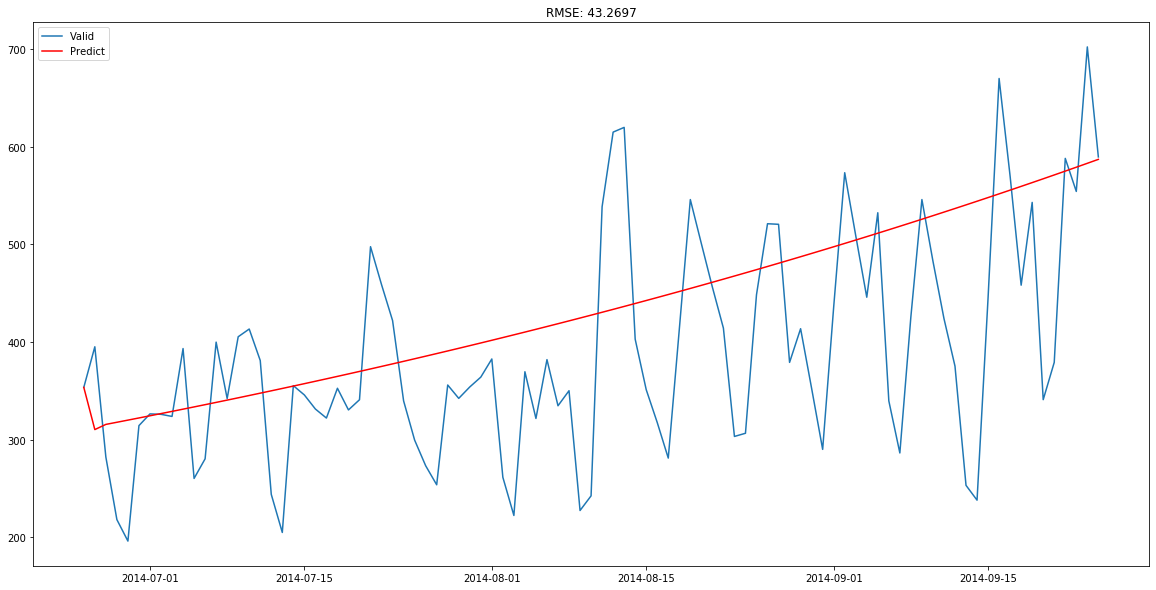

In [40]:
MA_predict = results_MA.predict(start='2014-06-25', end='2014-09-25')
# cumsum is applied to compensate the differencing performed
MA_predict = MA_predict.cumsum().shift().fillna(0)
MA_predict1 = pd.Series(
    np.ones(valid.shape[0])*np.log(valid['Count'])[0], index=valid.index)
MA_predict1 = MA_predict1.add(MA_predict, fill_value=0)
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label='Valid')
plt.plot(MA_predict, color='red', label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f' %
          (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()


Now let's combine these two models

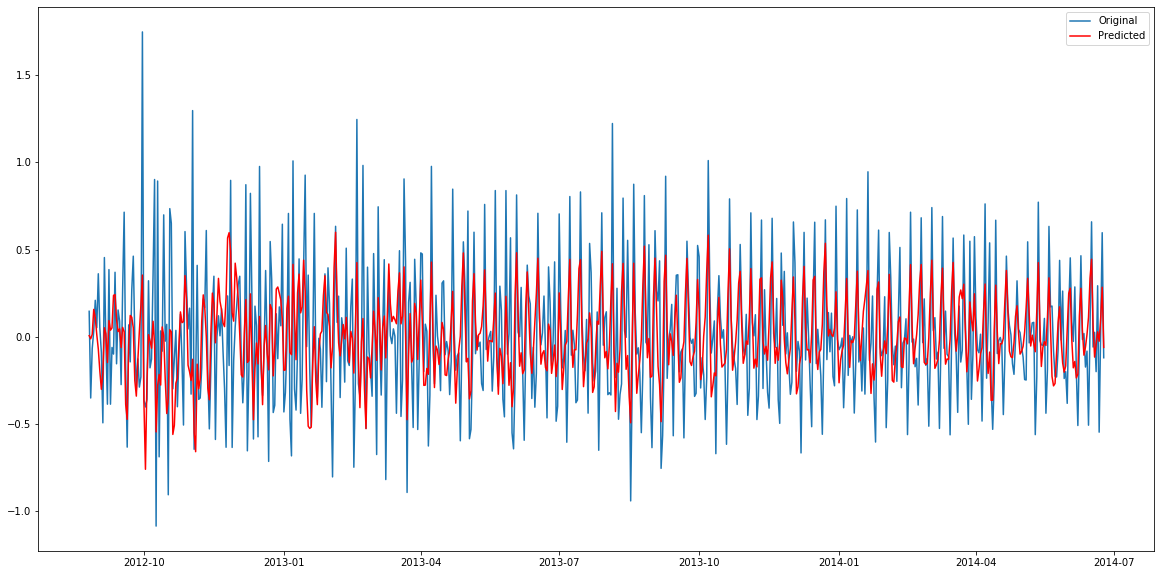

In [41]:
model = ARIMA(Train_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()


Let's define a function which can be used to change the scale of the model to the original scale.

In [42]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(
        given_set.shape[0])*np.log(given_set['Count'][0]), index=given_set.index)
    predict_log = predict_base.add(predict_diff, fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label='Given set')
    plt.plot(predict, color='red', label='Predict')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f' %
              (np.sqrt(np.dot(predict, given_set['Count']))/valid.shape[0]))
    plt.show()


def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label='Given set')
    plt.plot(predict, color='red', label='Predict')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f' %
              (np.sqrt(np.dot(predict, given_set['Count']))/valid.shape[0]))
    plt.show()


Let's predict the values for the validation set


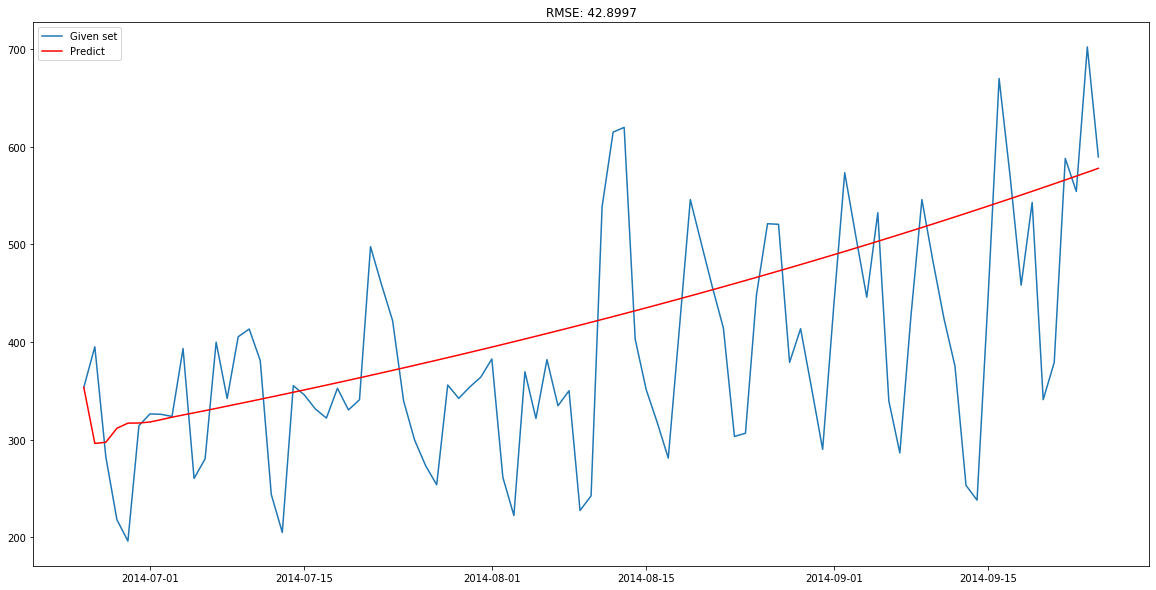

In [43]:
ARIMA_predict_diff = results_ARIMA.predict(
    start='2014-06-25', end='2014-09-25')
check_prediction_diff(ARIMA_predict_diff, valid)


We can check that the combination of the AR and the MA models gives a lower RMSE, in this case 42.8997

#### SARIMAX model on daily time series ####

SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


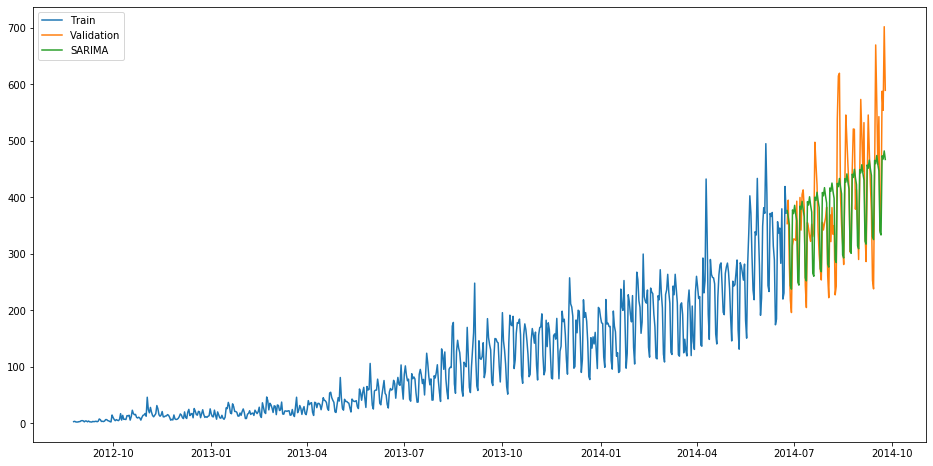

In [44]:
import statsmodels.api as sm

y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(
    2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(
    start='2014-6-25', end='2014-9-25', dynamic=True)
plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Validation')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()


    * Order in the above model represents the order of the autoregressive model (number of time lags), the degree of differencing (number of times the data have had past values substracted) and the order of the moving average model.
    * Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters and periodicity.
    * In this case periodicity is 7 since it is a daily time series and will repeat after every 7 days.

Let's check the RMSE value for the validation part.

In [45]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)


69.67242279085332


Now we will forecast the time series of Test data which starts from 2014-6-26 and ends at 2015-4-26

In [46]:
predict = fit1.predict(start='2014-6-26', end='2015-4-26', dynamic=True)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


These are daily predicitions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions with the same ratio.

In [47]:
test['prediction'] = predict
# Merge Test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge['Hour'] = merge['hour_y']
merge = merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y','ID_x','ID_y'], axis=1)

# Predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour',how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

KeyError: 'hour'

0        1
1        1
2        1
3        1
4        1
        ..
18283    0
18284    0
18285    0
18286    0
18287    0
Name: Datetime, Length: 18288, dtype: int64